### What is ProCapNet?
Author: Jacob Schreiber \<jmschreiber91@gmail.com\>

#### Introduction

ProCapNet (https://www.encodeproject.org/files/ENCFF976FHE/@@download/ENCFF976FHE.tar.gz)

##### Loading ProCapNet models

Using ProCapNet is almost identical to using a standard BPNet model except with one notable difference: because the ProCapNet codebase is based off an earlier version of bpnet-lite, the trained models are already in torch. This means that you can either use `torch.load` if you have the full model, or the code below if you only have the state dictionary.

In [94]:
import torch
import tarfile

from io import BytesIO
from bpnetlite import BPNet

with tarfile.open("ENCFF976FHE.tar.gz", "r:gz") as tar:
    model_tar = tar.extractfile("./fold_0/ENCSR261KBX.procapnet_model.fold0.state_dict.torch").read()
    model_state_dict = torch.load(BytesIO(model_tar))

model = BPNet(n_filters=512, n_control_tracks=0).cuda()
model.load_state_dict(model_state_dict)
model

AttributeError: '_IncompatibleKeys' object has no attribute 'cuda'

In [ ]:
### Predictions

In [100]:
import pyfaidx
from tangermeme.utils import one_hot_encode

chrom, mid = "chrX", 73_852_753
start, end = mid - 1057, mid + 1057

X = pyfaidx.Fasta("../../../../common/hg38.fa")[chrom][start:end].seq.upper()
X = one_hot_encode(X)[None].float().cuda()
X.shape

torch.Size([1, 4, 2114])

In [101]:
from tangermeme.predict import predict

y_profile, y_counts = predict(model, X)
y_profile = torch.softmax(y_profile.reshape(1, -1), dim=-1).reshape(*y_profile.shape)

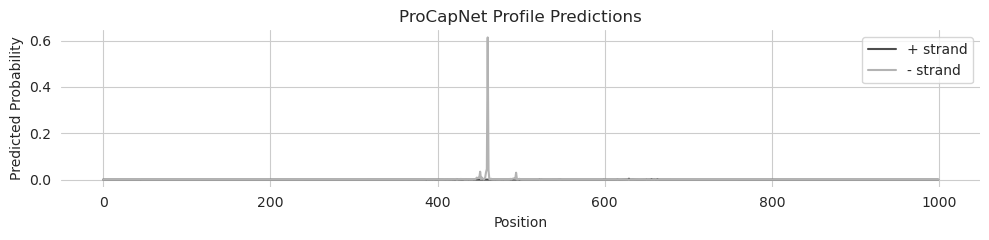

In [102]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(10, 2.5))
plt.plot(y_profile[0, 0], c='0.3', label="+ strand")
plt.plot(y_profile[0, 1], c='0.7', label="- strand")

plt.title("ProCapNet Profile Predictions")
plt.ylabel("Predicted Probability")
plt.xlabel("Position")

plt.legend()
plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

In [103]:
#### Attributions at CTCF locus

In [104]:
from bpnetlite.bpnet import ProfileWrapper
from bpnetlite.attribute import deep_lift_shap

X_attr = deep_lift_shap(ProfileWrapper(model), X, verbose=True)

/home/jmschrei/github/tangermeme/tangermeme/deep_lift_shap.py:460: RuntimeWarning: Convergence deltas too high: tensor([0.0008, 0.0010, 0.0005, 0.0010, 0.0012, 0.0008, 0.0007, 0.0009, 0.0014,
        0.0006, 0.0014, 0.0013, 0.0004, 0.0009, 0.0006, 0.0002, 0.0013, 0.0011,
        0.0264, 0.0055], device='cuda:0', grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 195.11it/s]


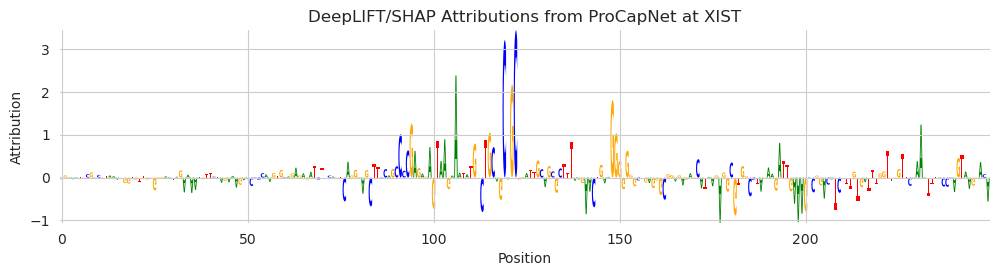

In [105]:
from tangermeme.plot import plot_logo

plt.figure(figsize=(12, 2.5))
plot_logo(X_attr[0, :, 1057-150:1057+100])
plt.xlabel("Position")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP Attributions from ProCapNet at XIST")
plt.show()

##### Design of a promoter active on a specified strand

In [116]:
from ledidi import ledidi

class StrandWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X):
        profile, _ = self.model(X)
        profile = torch.logsumexp(profile, dim=-1)
        profile = profile - torch.logsumexp(profile, dim=-1)[:, None]
        return profile

wrapper = StrandWrapper(model)

In [117]:
y_bar = torch.tensor([[0.0, -8.0]])

X_bar = ledidi(wrapper, X, y_bar, verbose=True)

iter=I	input_loss=0.0	output_loss=37.29	total_loss=37.29	time=0.0
iter=100	input_loss=46.0	output_loss=0.1649	total_loss=4.765	time=5.206
iter=200	input_loss=34.88	output_loss=0.2399	total_loss=3.727	time=3.164
iter=300	input_loss=36.12	output_loss=0.1056	total_loss=3.718	time=3.168
iter=F	input_loss=32.62	output_loss=0.08546	total_loss=3.348	time=13.66


In [120]:
predict(wrapper, X_bar)

tensor([[-6.7711e-04, -7.2977e+00],
        [-4.8542e-04, -7.6310e+00],
        [-4.3964e-04, -7.7303e+00],
        [-7.0286e-04, -7.2600e+00],
        [-4.6730e-04, -7.6680e+00],
        [-5.1975e-04, -7.5632e+00],
        [-5.1308e-04, -7.5745e+00],
        [-4.3392e-04, -7.7428e+00],
        [-5.1212e-04, -7.5766e+00],
        [-5.1498e-04, -7.5720e+00],
        [-4.4155e-04, -7.7263e+00],
        [-3.7384e-04, -7.8917e+00],
        [-2.7084e-04, -8.2156e+00],
        [-5.2643e-04, -7.5491e+00],
        [-5.4455e-04, -7.5152e+00],
        [-3.5477e-04, -7.9441e+00]])

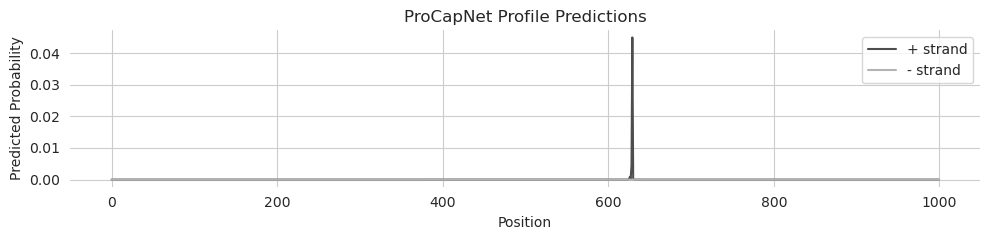

In [123]:
profile, counts = predict(model, X_bar)
profile = torch.softmax(profile.reshape(1, -1), dim=-1).reshape(*profile.shape)

plt.figure(figsize=(10, 2.5))
plt.plot(profile[0, 0], c='0.3', label="+ strand")
plt.plot(profile[0, 1], c='0.7', label="- strand")

plt.title("ProCapNet Profile Predictions")
plt.ylabel("Predicted Probability")
plt.xlabel("Position")

plt.legend()
plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()